In [ ]:
#Trade group
#Christina

In [ ]:
#Helpful links:
#SOURCE: https://www.census.gov/data/developers/data-sets/international-trade.html
#DOCUMENTATION: https://www.census.gov/foreign-trade/reference/guides/Guide%20to%20International%20Trade%20Datasets.pdf
#NAICS ENDPOINT DOCUMENTATION: https://api.census.gov/data/timeseries/intltrade/imports/naics/variables.html

In [ ]:
#Useful dates:
#March 1 = announced
#March 8 = signed
#March 23 = in effect

In [1]:
# Import dependencies
import requests
import pandas as pd
import numpy as np
import datetime as dt
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from pprint import pprint

In [2]:
# Census Trade API Key
from config import api_key
from pprint import pprint

In [3]:
# Set-up request
base_url = "https://api.census.gov/data/timeseries/intltrade/imports/naics"
# Interested in steel and aluminum (NAICS==331)
    # Motivation: https://www.usatoday.com/story/news/politics/2018/03/08/trump-planning-make-formal-tariff-announcement/406065002/
    # Motivation: https://taxfoundation.org/new-tariffs-could-cost-states-9-billion/
    # NAICS info: https://www.bls.gov/iag/tgs/iag331.htm

In [4]:
#SET UP INITIAL PARAMETERS

#CON_CHA_MO = (monthly) 15-digit Imports for Consumption, Charges
#CON_VAL_MO = (monthly) Imports for Insurance and Freight
#CON_CIF_MO = (monthly) 15-digit Aggregate of the above two

#CTY_NAME = 50-character Country Name
#NAICS_LDESC = 150-character NAICS Description
#NAICS_SDESC = 50-character NAICS Description

#CTY_CODE = 4-character Country Code
#https://www.census.gov/foreign-trade/schedules/c/country.txt
#NAICS = 2-, 3-, 4-, or 6-character NAICS code

params = {
    "key": api_key,
    "get" : "CON_CHA_MO,CTY_NAME,CON_CIF_MO,CON_VAL_MO,NAICS,NAICS_LDESC,NAICS_SDESC",
    "COMM_LVL": "NA3",
}

#Add these in the appropriate loop
#MONTH = 2-character Month 02 03 04
#YEAR = 4-character Year

In [5]:
#Set up a dictionary of results
results = {"year":[],"month":[],"imports":[],"country":[],"naics":[],"naics_desc":[]}

In [6]:
#initialize the first and last dates
begin_date = parser.parse("Jan 2013")
end_date = parser.parse("Feb 2018")

In [7]:
#initialize an array of dates in-between these
dateList = []
dateList.append(begin_date)
counta = 1
while dateList[counta-1]<(end_date-dt.timedelta(weeks = 4.345)):
    dateList.append(dateList[counta-1] + dt.timedelta(weeks = 4.345))
    counta +=1

In [8]:
#Look at multiple NAICS codes
#331 = Primary Metal Manufacturing
#323 = Printing and Related Support
#321 = Wood Product Manufacturing
naics_list = ["331","331","331","323","321"]
#Look at multiple countries
#6021 = Australia
#5880 = Japan
#5800 = South Korea
#5700 = China
country_list = ["5880","5800","5700","5700","5700"]

In [9]:
#Collect my data
for naics,country in zip(naics_list,country_list):
    for date in dateList:
        #Finish modifying parameters
        if len(str(date.month))==1:
            month = "0"+str(date.month)
        else :
            month = str(date.month)
        year = date.year
        params["NAICS"]=naics
        params['MONTH']=month
        params['YEAR']=year
        params['CTY_CODE']=country

        #Make the pull
        trade_data = requests.get(base_url, params=params)
        #print(trade_data.url)
        trade_data = trade_data.json()

        #Save the results (don't forget to convert later to csv)
        results['year'].append(year)
        results['month'].append(month)
        results['country'].append(trade_data[1][1])
        results['naics'].append(trade_data[1][4]) 
        results['naics_desc'].append(trade_data[1][5]) 
        results['imports'].append(trade_data[1][0]) 

In [10]:
#Set-up a df with my results
trade_df = pd.DataFrame(
    {"Exporter": results['country'],
     "Year": results['year'],
     "Month": results['month'],
     "Imports": results['imports'],
     "NAICS": results['naics'],
     "NAICS Description": results['naics_desc']
    })

In [11]:
#Create an indexable time
trade_df["time"] = trade_df["Year"].map(str) + "-" + trade_df["Month"].map(str)

In [12]:
trade_df.head()

,Exporter,Imports,Month,NAICS,NAICS Description,Year,time
0,JAPAN,16057727,01,331,PRIMARY METAL MANUFACTURING,2013,2013-01
1,JAPAN,15693694,02,331,PRIMARY METAL MANUFACTURING,2013,2013-02
2,JAPAN,18818107,03,331,PRIMARY METAL MANUFACTURING,2013,2013-03
3,JAPAN,25268650,04,331,PRIMARY METAL MANUFACTURING,2013,2013-04
4,JAPAN,20168944,05,331,PRIMARY METAL MANUFACTURING,2013,2013-05


In [13]:
#Slice df into two parts
trade_n331 = trade_df.loc[trade_df['NAICS'] == '331'][:]
trade_china = trade_df.loc[trade_df['Exporter'] == 'CHINA'][:]

In [14]:
#Reformat china only df by naics code
trade_china_piv = trade_china.pivot(index='time',columns='NAICS',values='Imports')
trade_china_piv.head()

NAICS,321,323,331
time,,,
2013-01,34776867,12465330,25734682
2013-02,34558507,11127992,21541610
2013-03,17007832,7596778,20639956
2013-04,30110646,10566373,21956205
2013-05,27230156,13366350,28201048


In [24]:
#Set up a dictionary of Chinese imports
#imports_china = {"321":[],"323":[],"331":[]}
for naics, coln in zip(["331","323","321"],["n331","n323","n321"]):
    trade_china_piv[coln]=pd.to_numeric(trade_china_piv[naics], errors='coerce')
trade_china_piv.head()

NAICS,321,323,331,n331,n323,n321,d331
time,,,,,,,
2013-01,34776867,12465330,25734682,25734682,12465330,34776867,-4193072.0
2013-02,34558507,11127992,21541610,21541610,11127992,34558507,-901654.0
2013-03,17007832,7596778,20639956,20639956,7596778,17007832,1316249.0
2013-04,30110646,10566373,21956205,21956205,10566373,30110646,6244843.0
2013-05,27230156,13366350,28201048,28201048,13366350,27230156,-3691822.0


In [33]:
trade_china_piv=trade_china_piv.drop(columns=['331','323','321'])
trade_china_piv.head()

NAICS,n331,n323,n321,d331
time,,,,
2013-01,25734682,12465330,34776867,-4193072.0
2013-02,21541610,11127992,34558507,-901654.0
2013-03,20639956,7596778,17007832,1316249.0
2013-04,21956205,10566373,30110646,6244843.0
2013-05,28201048,13366350,27230156,-3691822.0


In [34]:
#Show the greatest changes in NAICS 331
trade_china_piv['d331'] = (trade_china_piv['n331'].shift(-1) - trade_china_piv['n331'])
trade_china_piv.head()

NAICS,n331,n323,n321,d331
time,,,,
2013-01,25734682,12465330,34776867,-4193072.0
2013-02,21541610,11127992,34558507,-901654.0
2013-03,20639956,7596778,17007832,1316249.0
2013-04,21956205,10566373,30110646,6244843.0
2013-05,28201048,13366350,27230156,-3691822.0


In [48]:
#December to January = third largest increase in volume within the past five years
trade_china_piv.sort_values(by=['d331']).tail().drop(columns=['n323','n321'])

NAICS,n331,d331
time,,
2014-08,28762378,7077313.0
2017-12,22177341,7105469.0
2015-02,32475075,7673913.0
2014-03,22653729,14046917.0
2018-02,21271886,NaN


In [49]:
#January to February = second largest decrease of volume within the past five years
trade_china_piv.sort_values(by=['d331']).head().drop(columns=['n323','n321'])

NAICS,n331,d331
time,,
2014-10,41627107,-8286745.0
2018-01,29282810,-8010924.0
2015-07,35726548,-6534915.0
2015-05,38866123,-5508321.0
2013-07,27539984,-5214809.0


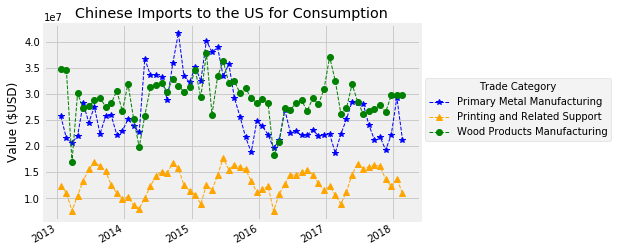

In [44]:
plt.title("Chinese Imports to the US for Consumption")
plt.ylabel("Value ($USD)")

#plt.xlim(0, x_lim)
#plt.ylim(-1.25, 1.25)

for l,n,m,c in zip(['Primary Metal Manufacturing', 'Chemicals Manufacturing', 'Wood Products Manufacturing']
                   ,["n331","n323","n321"]
                   ,['*','^','o']
                   ,['blue','orange','green']) :
    plt.plot(dateList, trade_china_piv[n], '--', color=c, label="%s" %l, marker=m, linewidth=1)

plt.legend(['Primary Metal Manufacturing', 
            'Printing and Related Support',
            'Wood Products Manufacturing'],
           title= 'Trade Category',
           bbox_to_anchor=(1, 0.75)
          )

# Beautify the x-labels
plt.gcf().autofmt_xdate()

# Save the figure
plt.savefig("Imports_China_byCat.png")

plt.show()

In [45]:
#Reformat naics 331 only df by exporting country
trade_n331_piv = trade_n331.pivot(index='time',columns='Exporter',values='Imports')
trade_n331_piv=trade_n331_piv.rename(columns={"JAPAN": "Japan", 
                                              "CHINA": "China", 
                                              "KOREA, SOUTH": "South Korea"})
trade_n331_piv.head()

Exporter,China,Japan,South Korea
time,,,
2013-01,25734682,16057727,25827085
2013-02,21541610,15693694,18564755
2013-03,20639956,18818107,23958722
2013-04,21956205,25268650,25389578
2013-05,28201048,20168944,22291794


In [46]:
#Set up a dictionary of Primary Metal Manufacturing imports
imports_321 = {"China":[],"South Korea":[],"Japan":[]}
for country in ["China","South Korea","Japan"]:
    imports_321[country]=pd.to_numeric(trade_n331_piv[country], errors='coerce')

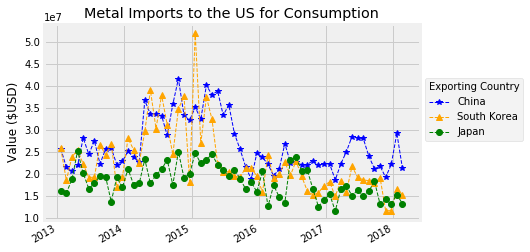

In [47]:
plt.title("Metal Imports to the US for Consumption")
plt.ylabel("Value ($USD)")

for n,m,c in zip(["China","South Korea","Japan"]
                   ,['*','^','o']
                   ,['blue','orange','green']) :
    plt.plot(dateList, imports_321[n], '--', color=c, label="%s" %n, marker=m, linewidth=1)

plt.legend(["China",
            "South Korea",
            "Japan"],
           title= 'Exporting Country',
           bbox_to_anchor=(1, 0.75)
          )

# Beautify the x-labels
plt.gcf().autofmt_xdate()

# Save the figure
plt.savefig("Imports_Metals_byCountry.png")

plt.show()